## Experimento 5. 
## Análisis del envío de remesas o acumulación de ahorros durante el último viaje migratorio

Selección y limpieza de datos a partir de las tablas <b>MIG</b>, <b>LIFE</b> y <b>COMMUN</b>.

Para este experimento se considera solamente información pertinente al último viaje migratorio realizado, creando una etiqueta de clase a partir de los atributos 'remit1'...'remit5' y 'savretrn'. 

Así, la etiqueta de clase puede tomar dos valores posibles:<br>
>1: Sí (Si la persona envió remesas o regresó con ahorros a México)<br>0: No (Si no envió remesas ni regresó con ahorros)<br>
---

In [1]:
#Formato: (clase, label)
    #clase: valor numérico
    #label: valor de texto (etiqueta)
#¿La persona envió remesas o regresó con ahorros a México?
pos_class = (1, 'Sí') #Clase positive (Sí)
neg_class = (0, 'No') #Clase negative  (No)

# Tareas previas
Añadir librerías, cargar dataset, generar dfs. calcular IR e imputar datos.

### Añadir librerías necesarias

In [49]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from tabulate import tabulate
from scipy.spatial.distance import mahalanobis

sys.path.append(os.path.abspath(os.path.join('..'))) #Utils path
from tesis_experiments_utils import classifiers_utils as cu
from tesis_experiments_utils import confusion_matrices_utils as cmu
from tesis_experiments_utils import data_utils as du
from tesis_experiments_utils import files_utils as fu
from tesis_experiments_utils import learning_curves_utils as lcu

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### Cargar el dataset en un dataframe y generar los df con los datos y etiquetas

Variables para la lectura del dataset

Crear carpetas para almacenamiento de los resultados, particiones de datos, etc.

In [3]:
fu.setup_folders()

La carpeta 'particiones/hold_out' ha sido creada
La carpeta 'datos_imputados' ha sido creada
La carpeta 'matrices_de_confusion' ha sido creada
La carpeta 'curvas_de_aprendizaje' ha sido creada
La carpeta 'resultados' ha sido creada


In [4]:
#Ubicación del dataset
path_to_data = os.path.join('..', 'datasets')
path_to_file = os.path.join(path_to_data,'remesas_clasificacion', 'remesas_clasificacion.csv')


#Atributos categóricos del dataset
cat_atts = ['sex', 'usmarl', 'usdocl', 'reltrip', 'paistrip', 
            'sport', 'social', 'inus', 'METROCAT', 'pre_irca', 'irca', 'iirira','pais_pre_irca', 'pais_irca', 'pais_iirira']

## Métodos de validación
Definición de variables y métodos necesarios para los métodos de validación Hold-out y k-fold-cross-validation

Realizar partición de datos con Hold-out

In [5]:
X_train, X_test, y_train, y_test = du.stratified_hold_out(path_to_file, cat_atts, test_size=0.2)
X = pd.concat([X_train, X_test])

Archivo 'X_train.csv' no encontrado en 'particiones/hold_out/0.80_0.20'
Generando una nueva partición de datos hold out 0.80-0.20. Almacenando en: 'particiones/hold_out/0.80_0.20'

Se ha generado y almacenado una nueva partición de datos en 'particiones/hold_out/0.80_0.20'


### K-fold Cross Validation

In [6]:
kf_cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

### Cálculo de Imbalance Ratio

In [7]:
y = np.concatenate((y_train, y_test))

card_class1 = sum(1 for l in y if l == pos_class[0]) #Cardinalidad de la clase 1
card_class2 = sum(1 for l in y if l == neg_class[0]) #Cardinalidad de la clase 2

IR = max(card_class1,card_class2)/min(card_class1,card_class2)

print("Instancias en el dataset: %i" % len(y))
print("Cadinalidad de la clase 1: %i" % card_class1)
print("Cadinalidad de la clase 2: %i" % card_class2)


if(IR <= 1.5):
  print("Dataset balanceado con IR = %.4f" % IR)
else:
  print("Dataset desbalanceado con IR = %.4f" % IR)


Instancias en el dataset: 2268
Cadinalidad de la clase 1: 1127
Cadinalidad de la clase 2: 1141
Dataset balanceado con IR = 1.0124


## Imputación de datos perdidos

In [8]:
X_train, X_test = du.impute_data(X_train, X_test, cat_atts,'median')

Archivo 'X_train_imputed_median.csv' no encontrado en 'datos_imputados'
Imputando valores faltantes en los conjuntos de datos utilizando la estrategia 'median'

Se han imputado y almacenado los conjuntos de datos en 'datos_imputados'


## Normalización del dataset para utilizarlo con clasificadores basádos en métricas

Normalización de los atributos del dataset utilizando la forma:

$
    \Large z = \frac{(x-\mu)}{\sigma}
$

También conocida como z-score

In [9]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out()) # type: ignore
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out()) # type: ignore

## One hot encoding sobre atributos categóricos para utilizarlo con clasificadores basados en reglas

In [10]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
#pd.concat(atributos no categóricos, atributos categóricos codificados, nombre de columnas, axis)
X_train_encoded = pd.concat([X_train.drop(cat_atts, axis=1), 
                             pd.DataFrame(encoder.fit_transform(X_train[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)
X_test_encoded = pd.concat([X_test.drop(cat_atts, axis=1),
                            pd.DataFrame(encoder.transform(X_test[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)

Medidas de desempeño para cross validation y learning curve

In [11]:
scoring = ['accuracy', 'matthews_corrcoef'] #Métricas de evaluación para selección de modelos
score_validation = 'accuracy' #Métrica de evaluación para learning curve

# Clasificadores k-NN

Experimentación con la distancia de Mahalanobis

In [12]:
cov_matrix = np.cov(X_train_scaled.T)

def mahalanobis_distance(X, y):
    return mahalanobis(X, y, np.linalg.inv(cov_matrix))

### **Elección del parámetro k**

Elección del parámetro k que minimiza el error de generalización utilizando *10-fold cross validation* a partir del Coeficiente de Correlación de Matthews.

In [13]:
k_range = range(1,52,2)
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
params = {'n_neighbors': k_range, 'metric': metrics}
knn = KNeighborsClassifier()

best_knn = GridSearchCV(knn,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit =score_validation, verbose=3)
start = time.time()
best_knn.fit(X_train_scaled, y_train)
end = time.time()
best_score = best_knn.best_score_
best_k = best_knn.best_params_['n_neighbors']
best_metric = best_knn.best_params_['metric']
fu.write_cross_val_times_to_file(
        {"Classifier": f'{best_k}-NN', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Mejor k: {best_k}, mejor métrica: {best_metric}, {score_validation} media: {best_score:.4f}.')

Fitting 10 folds for each of 104 candidates, totalling 1040 fits
[CV 1/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.555) matthews_corrcoef: (test=0.110) total time=   0.0s[CV 3/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.560) matthews_corrcoef: (test=0.120) total time=   0.0s

[CV 4/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.544) matthews_corrcoef: (test=0.087) total time=   0.0s
[CV 2/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.533) matthews_corrcoef: (test=0.065) total time=   0.0s
[CV 5/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.525) matthews_corrcoef: (test=0.050) total time=   0.0s
[CV 6/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.514) matthews_corrcoef: (test=0.027) total time=   0.0s
[CV 7/10] END metric=euclidean, n_neighbors=1; accuracy: (test=0.536) matthews_corrcoef: (test=0.072) total time=   0.0s
[CV 7/10] END metric=euclidean, n_neighbors=3; accuracy: (test=0.530) matthews_corrcoef:

Archivo de curvas de aprendizaje creado en curvas_de_aprendizaje/curvas_de_aprendizaje.csv
Curvas de aprendizaje del clasificador 35-NN almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Archivo de tiempos de curvas de aprendizaje creado en curvas_de_aprendizaje/learning_curves_times.csv
Tiempo de curvas de aprendizaje del clasificador 35-NN almacenado en curvas_de_aprendizaje/learning_curves_times.csv


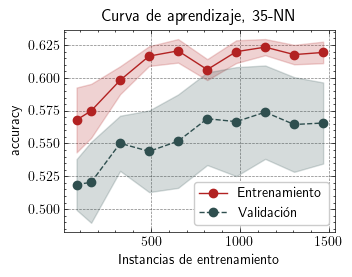

In [14]:
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
lcu.plot_and_save_learning_curve(knn, f'{best_k}-NN',X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10,y_label=score_validation)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Archivo de resultados creado en resultados/resultados.csv
Resultados del clasificador 35-NN almacenados en resultados/resultados.csv
Archivo de predicciones creado en resultados/predicciones.csv
Predicciones del clasificador 35-NN almacenadas en resultados/predicciones.csv.
Archivo de tiempos de ejecución creado en resultados/execution_times.csv
Tiempo de ejecución del clasificador 35-NN almacenado en resultados/execution_times.csv
Accuracy: 0.5859
Balanced accuracy: 0.5849
Recall: 0.3496
Specificity: 0.8202
AUC: 0.3496
MCC: 0.1925
Precision: 0.6583
F1-score: 0.4566


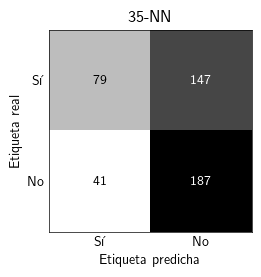

In [15]:
cu.train_and_evaluate_model(knn, X_train_scaled, y_train, X_test_scaled, y_test, f'{best_k}-NN',pos_class,neg_class)

# Naïve Bayes

### **Naïve Bayes**

Curvas de aprendizaje del clasificador Naïve Bayes almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador Naïve Bayes almacenado en curvas_de_aprendizaje/learning_curves_times.csv


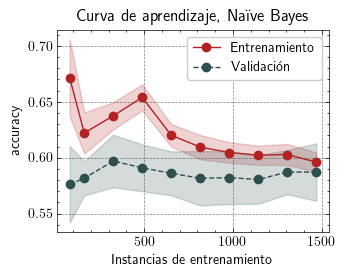

In [16]:
fu.write_cross_val_times_to_file(
        {"Classifier": 'Naïve Bayes', "time_s": 0}
)
nb = GaussianNB()
lcu.plot_and_save_learning_curve(nb, 'Naïve Bayes',X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10, y_label=score_validation)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
Predicciones del clasificador Naïve Bayes almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador Naïve Bayes almacenado en resultados/execution_times.csv
Accuracy: 0.6035
Balanced accuracy: 0.6020
Recall: 0.2611
Specificity: 0.9430
AUC: 0.2611
MCC: 0.2793
Precision: 0.8194
F1-score: 0.3960


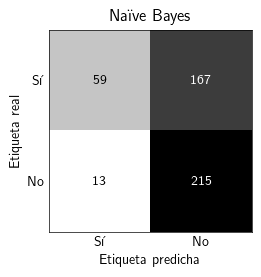

In [17]:
cu.train_and_evaluate_model(nb, X_train_encoded, y_train, X_test_encoded, y_test, 'Naïve Bayes',pos_class,neg_class)

# Decision Tree

In [18]:
depth_range = range(1,52)
params = {'max_depth': depth_range}
dtree = DecisionTreeClassifier()
best_tree = GridSearchCV(dtree,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit =score_validation, verbose=3)
start = time.time()
best_tree.fit(X_train_encoded, y_train)
end = time.time()
t1 = end-start
best_score = best_tree.best_score_
best_depth = best_tree.best_params_['max_depth']

print(f'Best {score_validation}: {best_score}, best depth: {best_depth}')

Fitting 10 folds for each of 51 candidates, totalling 510 fits
[CV 1/10] END max_depth=1; accuracy: (test=0.621) matthews_corrcoef: (test=0.278) total time=   0.0s
[CV 2/10] END max_depth=1; accuracy: (test=0.593) matthews_corrcoef: (test=0.195) total time=   0.0s
[CV 3/10] END max_depth=1; accuracy: (test=0.615) matthews_corrcoef: (test=0.287) total time=   0.0s
[CV 4/10] END max_depth=1; accuracy: (test=0.593) matthews_corrcoef: (test=0.218) total time=   0.0s
[CV 6/10] END max_depth=1; accuracy: (test=0.552) matthews_corrcoef: (test=0.118) total time=   0.0s
[CV 5/10] END max_depth=1; accuracy: (test=0.591) matthews_corrcoef: (test=0.216) total time=   0.0s
[CV 7/10] END max_depth=1; accuracy: (test=0.597) matthews_corrcoef: (test=0.212) total time=   0.0s
[CV 8/10] END max_depth=1; accuracy: (test=0.547) matthews_corrcoef: (test=0.105) total time=   0.0s
[CV 10/10] END max_depth=1; accuracy: (test=0.575) matthews_corrcoef: (test=0.175) total time=   0.0s
[CV 9/10] END max_depth=1; 

In [19]:
min_samples_split_range = range(2,41)
min_samples_leaf_range = range(1,21)
params = {'min_samples_split': min_samples_split_range, 'min_samples_leaf':min_samples_leaf_range}
dtree = DecisionTreeClassifier(max_depth=best_depth)

best_tree = GridSearchCV(dtree,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit =score_validation, return_train_score=False, verbose=3)
start = time.time()
best_tree.fit(X_train_encoded, y_train)
end = time.time()
t2 = end-start
best_score = best_tree.best_score_
best_min_samples_split = best_tree.best_params_['min_samples_split']
best_min_samples_leaf = best_tree.best_params_['min_samples_leaf']
fu.write_cross_val_times_to_file(
        {"Classifier": 'Decision Tree', "time_s": t1+t2}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(t1+t2)))
print(best_min_samples_split, best_min_samples_leaf)

Fitting 10 folds for each of 780 candidates, totalling 7800 fits
[CV 1/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.599) matthews_corrcoef: (test=0.204) total time=   0.0s
[CV 3/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.659) matthews_corrcoef: (test=0.324) total time=   0.0s
[CV 2/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.604) matthews_corrcoef: (test=0.209) total time=   0.0s
[CV 4/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.632) matthews_corrcoef: (test=0.264) total time=   0.0s
[CV 5/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.652) matthews_corrcoef: (test=0.306) total time=   0.0s
[CV 6/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.635) matthews_corrcoef: (test=0.271) total time=   0.0s
[CV 7/10] END min_samples_leaf=1, min_samples_split=2; accuracy: (test=0.646) matthews_corrcoef: (test=0.295) total time=   0.0s
[CV 8/10] END min_samples_leaf=1

In [20]:
best_min_samples_split, best_min_samples_leaf

(2, 16)

Curvas de aprendizaje del clasificador Decision Tree almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador Decision Tree almacenado en curvas_de_aprendizaje/learning_curves_times.csv


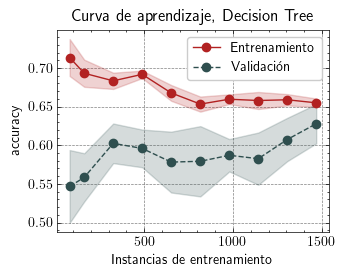

In [21]:
dtree = DecisionTreeClassifier(splitter="best", max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split)
lcu.plot_and_save_learning_curve(dtree, 'Decision Tree', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10, y_label=score_validation)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
Predicciones del clasificador Decision Tree almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador Decision Tree almacenado en resultados/execution_times.csv
Accuracy: 0.6586
Balanced accuracy: 0.6581
Recall: 0.5575
Specificity: 0.7588
AUC: 0.5575
MCC: 0.3230
Precision: 0.6961
F1-score: 0.6192


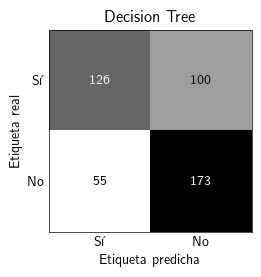

In [22]:
cu.train_and_evaluate_model(dtree, X_train_encoded, y_train, X_test_encoded, y_test, 'Decision Tree',pos_class,neg_class)

# Random Forest

In [23]:
rf = RandomForestClassifier(bootstrap=True, max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
n_estimators_range = range(100,1100,100)
params = {'n_estimators': n_estimators_range}
best_rf = GridSearchCV(rf,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit =score_validation, verbose=3)
start = time.time()
best_rf.fit(X_train_encoded, y_train) 
end = time.time()
best_score = best_tree.best_score_
best_n_estimators = best_rf.best_params_['n_estimators']
fu.write_cross_val_times_to_file(
        {"Classifier":'Random Forest', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best {score_validation}: {best_score}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 2/10] END n_estimators=100; accuracy: (test=0.599) matthews_corrcoef: (test=0.198) total time=   0.1s
[CV 4/10] END n_estimators=100; accuracy: (test=0.643) matthews_corrcoef: (test=0.287) total time=   0.1s
[CV 3/10] END n_estimators=100; accuracy: (test=0.626) matthews_corrcoef: (test=0.272) total time=   0.1s
[CV 6/10] END n_estimators=100; accuracy: (test=0.547) matthews_corrcoef: (test=0.095) total time=   0.2s
[CV 7/10] END n_estimators=100; accuracy: (test=0.652) matthews_corrcoef: (test=0.307) total time=   0.2s
[CV 9/10] END n_estimators=100; accuracy: (test=0.641) matthews_corrcoef: (test=0.287) total time=   0.2s
[CV 5/10] END n_estimators=100; accuracy: (test=0.652) matthews_corrcoef: (test=0.315) total time=   0.2s[CV 10/10] END n_estimators=100; accuracy: (test=0.608) matthews_corrcoef: (test=0.226) total time=   0.2s

[CV 1/10] END n_estimators=100; accuracy: (test=0.621) matthews_corrcoef: (test=0.248) t

Curvas de aprendizaje del clasificador Random Forest almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador Random Forest almacenado en curvas_de_aprendizaje/learning_curves_times.csv


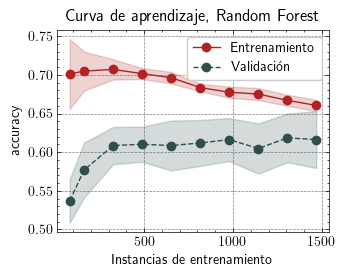

In [24]:
rf = RandomForestClassifier(n_estimators=best_n_estimators,max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
lcu.plot_and_save_learning_curve(rf, 'Random Forest', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10, y_label=score_validation)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
Predicciones del clasificador Random Forest almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador Random Forest almacenado en resultados/execution_times.csv
Accuracy: 0.6542
Balanced accuracy: 0.6534
Recall: 0.4823
Specificity: 0.8246
AUC: 0.4823
MCC: 0.3268
Precision: 0.7315
F1-score: 0.5813


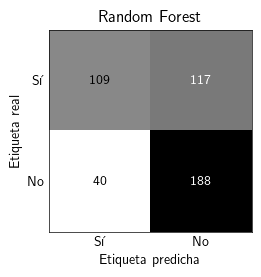

In [25]:
cu.train_and_evaluate_model(rf, X_train_encoded, y_train, X_test_encoded, y_test, 'Random Forest',pos_class,neg_class)

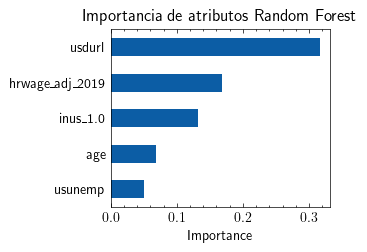

In [26]:
features=X_train_encoded.columns.to_list()
feature_imp = rf.feature_importances_

df_feature_imp_rf = pd.DataFrame({'importance': feature_imp}, index=features)

with plt.style.context('science'):
    ax = df_feature_imp_rf.sort_values(by='importance', ascending=True).tail().plot.barh()
    ax.set_title('Importancia de atributos Random Forest')
    ax.set_xlabel('Importance')
    ax.legend().remove()
plt.tight_layout()
ax.tick_params(axis='y', which='both',length=0)
plt.savefig(os.path.join(fu.results_path,'feature_importances_rf.png'), dpi=300, bbox_inches='tight')
plt.show()

# Gradient Boosting Machine (GBM)

In [27]:
gbm =  GradientBoostingClassifier(criterion='friedman_mse')
n_estimators_range = range(1000,1500,100)
params = {'n_estimators': n_estimators_range}
best_gbm = GridSearchCV(gbm,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit=score_validation, verbose=3)
start = time.time()
best_gbm.fit(X_train_scaled, y_train) 
end = time.time()
best_score = best_gbm.best_score_
best_n_estimators = best_gbm.best_params_['n_estimators']
fu.write_cross_val_times_to_file(
        {"Classifier":'GBM', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best {score_validation}: {best_score}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 9/10] END n_estimators=1000; accuracy: (test=0.657) matthews_corrcoef: (test=0.316) total time=   1.9s
[CV 10/10] END n_estimators=1000; accuracy: (test=0.558) matthews_corrcoef: (test=0.116) total time=   1.9s
[CV 2/10] END n_estimators=1000; accuracy: (test=0.621) matthews_corrcoef: (test=0.242) total time=   1.9s
[CV 3/10] END n_estimators=1000; accuracy: (test=0.621) matthews_corrcoef: (test=0.242) total time=   1.9s
[CV 1/10] END n_estimators=1000; accuracy: (test=0.610) matthews_corrcoef: (test=0.220) total time=   1.9s
[CV 4/10] END n_estimators=1000; accuracy: (test=0.637) matthews_corrcoef: (test=0.275) total time=   1.9s
[CV 7/10] END n_estimators=1000; accuracy: (test=0.624) matthews_corrcoef: (test=0.249) total time=   1.9s
[CV 8/10] END n_estimators=1000; accuracy: (test=0.641) matthews_corrcoef: (test=0.283) total time=   1.9s
[CV 5/10] END n_estimators=1000; accuracy: (test=0.646) matthews_corrcoef: (test=0

Curvas de aprendizaje del clasificador GBM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador GBM almacenado en curvas_de_aprendizaje/learning_curves_times.csv


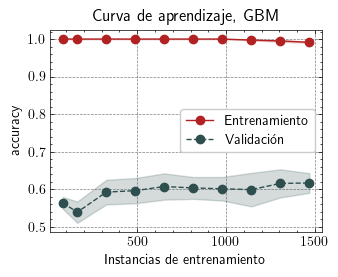

In [28]:
gbm = GradientBoostingClassifier(n_estimators=best_n_estimators, criterion='friedman_mse')
lcu.plot_and_save_learning_curve(gbm, 'GBM', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10, y_label=score_validation)

Tiempo de entrenamiento: 00:00:01
Tiempo de evaluación: 00:00:00
Resultados del clasificador GBM almacenados en resultados/resultados.csv
Predicciones del clasificador GBM almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador GBM almacenado en resultados/execution_times.csv
Accuracy: 0.6718
Balanced accuracy: 0.6717
Recall: 0.6372
Specificity: 0.7061
AUC: 0.6372
MCC: 0.3442
Precision: 0.6825
F1-score: 0.6590


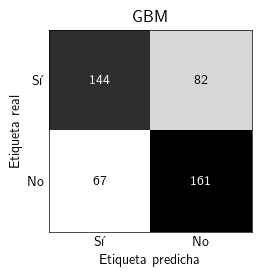

In [29]:
cu.train_and_evaluate_model(gbm, X_train_scaled, y_train, X_test_scaled, y_test, 'GBM', pos_class, neg_class)

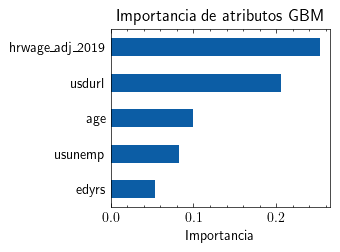

In [30]:
features=X_train_scaled.columns.to_list()
feature_imp = gbm.feature_importances_

df_feature_imp = pd.DataFrame({'importance': feature_imp}, index=features)

with plt.style.context('science'):
    ax = df_feature_imp.sort_values(by='importance', ascending=True).tail().plot.barh()
    ax.set_title('Importancia de atributos GBM')
    ax.set_xlabel('Importancia')
    ax.legend().remove()
plt.tight_layout()
ax.tick_params(axis='y', which='both',length=0)
plt.savefig(os.path.join(fu.results_path,'feature_importances_gbm.png'), dpi=300, bbox_inches='tight')
plt.show()

# Multi Layer Perceptron (MLP)

In [31]:
mlp =  MLPClassifier(max_iter=4500, learning_rate='adaptive')
hidden_layers_range = [(20,5),(20,10),(25,5),(25,10),(30,5),(30,10),(35,5),(35,10),(40,5),(40,10),(45,5),(45,10),
                       (50,5),(50,10),(55,5),(55,10),(60,5),(60,10),(65,5),(65,10),(70,5),(70,10),(75,5),(75,10),(80,5),(80,10),
                       (85,5),(85,10),(90,5),(90,10),(95,5),(95,10),(100,5),(100,10)] #Número de neuronas en dos capas ocultas del MLP
#hidden_layers_range = [(55,5),(55,10),(60,5),(60,10),(65,5),(65,10),(70,5),(70,10),(75,5),(75,10),(80,5),(80,10),
#                       (85,5),(85,10),(90,5),(90,10),(95,5),(95,10),(100,5),(100,10)] #Número de neuronas en dos capas ocultas del MLP
#hidden_layers_range = [(55,25),(55,30),(60,25),(60,30),(65,25),(65,30),(70,25),(70,30),(75,25),(75,30),(80,25),(80,30),
#                       (85,25),(85,30),(90,25),(90,30),(95,25),(95,30),(100,25),(100,30)] #Número de neuronas en dos capas ocultas del MLP
alpha_range = np.logspace(-5, 0, 7) #Parámetro de regularización L2
activations = ['logistic', 'tanh', 'relu']
params = {'hidden_layer_sizes': hidden_layers_range, 'alpha': alpha_range, 'activation': activations}
best_mlp = GridSearchCV(mlp,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit = score_validation,verbose=3)
start = time.time()
best_mlp.fit(X_train_scaled, y_train) 
end = time.time()
best_score = best_mlp.best_score_
best_alpha = best_mlp.best_params_['alpha']
best_hidden_layers = best_mlp.best_params_['hidden_layer_sizes']
best_activation = best_mlp.best_params_['activation']
fu.write_cross_val_times_to_file(
        {"Classifier":'MLP', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best {score_validation}: {best_score}, best hidden layers: {best_hidden_layers}, best alpha: {best_alpha}, best activation: {best_activation}')

Fitting 10 folds for each of 714 candidates, totalling 7140 fits
[CV 4/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(20, 5); accuracy: (test=0.588) matthews_corrcoef: (test=0.181) total time=   0.5s
[CV 6/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(20, 10); accuracy: (test=0.564) matthews_corrcoef: (test=0.130) total time=   0.7s
[CV 10/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(20, 5); accuracy: (test=0.586) matthews_corrcoef: (test=0.172) total time=   4.1s
[CV 5/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(20, 10); accuracy: (test=0.558) matthews_corrcoef: (test=0.116) total time=   4.6s
[CV 3/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(20, 10); accuracy: (test=0.599) matthews_corrcoef: (test=0.198) total time=   4.7s
[CV 9/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(20, 5); accuracy:

Curvas de aprendizaje del clasificador MLP almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador MLP almacenado en curvas_de_aprendizaje/learning_curves_times.csv


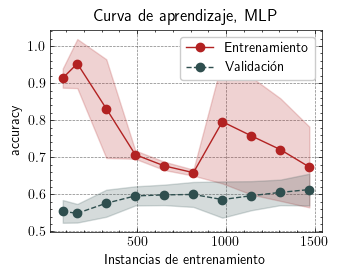

In [32]:
mlp =  MLPClassifier(hidden_layer_sizes=best_hidden_layers,alpha=best_alpha, activation=best_activation, max_iter=4500, learning_rate='adaptive')
lcu.plot_and_save_learning_curve(mlp, 'MLP', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10, y_label=score_validation)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador MLP almacenados en resultados/resultados.csv
Predicciones del clasificador MLP almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador MLP almacenado en resultados/execution_times.csv
Accuracy: 0.6123
Balanced accuracy: 0.6117
Recall: 0.4646
Specificity: 0.7588
AUC: 0.4646
MCC: 0.2338
Precision: 0.6562
F1-score: 0.5440


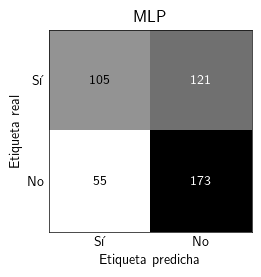

In [33]:
#mlp.out_activation_ = 'logistic'
cu.train_and_evaluate_model(mlp, X_train_scaled, y_train, X_test_scaled, y_test, 'MLP', pos_class, neg_class)

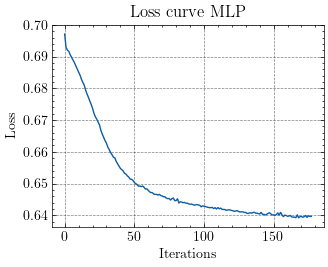

In [34]:
with plt.style.context(['science','grid']):
    fig, ax = plt.subplots()
    ax.plot(mlp.loss_curve_)
    ax.set_title('Loss curve MLP')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    plt.savefig(os.path.join(fu.results_path,'MLP_loss_curve.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Support Vector Machines (SVMs)

## SVM con kernel lineal

## SVM con kernel RBF Gaussiana

In [35]:
rsvm = SVC(kernel='rbf')
C_range = np.logspace(-3, 0, 7)
gamma_range = np.logspace(-3, 0, 7)
params = {'C': C_range, 'gamma': gamma_range}
best_rsvm = GridSearchCV(rsvm,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit =score_validation, verbose=3)
start = time.time()
best_rsvm.fit(X_train_scaled, y_train)
end = time.time()
best_score = best_rsvm.best_score_
best_C = best_rsvm.best_params_['C']
best_gamma = best_rsvm.best_params_['gamma']
fu.write_cross_val_times_to_file(
        {"Classifier":'RBF SVM', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best {score_validation}: {best_score}, best C: {best_C}, best gamma: {best_gamma}')

Fitting 10 folds for each of 49 candidates, totalling 490 fits
[CV 4/10] END C=0.001, gamma=0.001; accuracy: (test=0.505) matthews_corrcoef: (test=0.000) total time=   0.1s
[CV 7/10] END C=0.001, gamma=0.001; accuracy: (test=0.503) matthews_corrcoef: (test=0.000) total time=   0.1s
[CV 8/10] END C=0.001, gamma=0.001; accuracy: (test=0.503) matthews_corrcoef: (test=0.000) total time=   0.1s
[CV 2/10] END C=0.001, gamma=0.0031622776601683794; accuracy: (test=0.505) matthews_corrcoef: (test=0.000) total time=   0.1s
[CV 2/10] END C=0.001, gamma=0.001; accuracy: (test=0.505) matthews_corrcoef: (test=0.000) total time=   0.1s
[CV 3/10] END C=0.001, gamma=0.001; accuracy: (test=0.505) matthews_corrcoef: (test=0.000) total time=   0.1s
[CV 5/10] END C=0.001, gamma=0.001; accuracy: (test=0.503) matthews_corrcoef: (test=0.000) total time=   0.1s
[CV 6/10] END C=0.001, gamma=0.001; accuracy: (test=0.503) matthews_corrcoef: (test=0.000) total time=   0.1s
[CV 4/10] END C=0.001, gamma=0.0031622776

Curvas de aprendizaje del clasificador RBF SVM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador RBF SVM almacenado en curvas_de_aprendizaje/learning_curves_times.csv


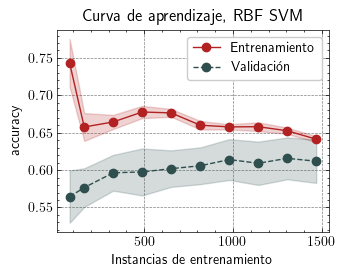

In [36]:
rsvm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
lcu.plot_and_save_learning_curve(rsvm, 'RBF SVM', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10, n_jobs=-1, y_label=score_validation)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
Predicciones del clasificador RBF SVM almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador RBF SVM almacenado en resultados/execution_times.csv
Accuracy: 0.6211
Balanced accuracy: 0.6201
Recall: 0.3717
Specificity: 0.8684
AUC: 0.3717
MCC: 0.2768
Precision: 0.7368
F1-score: 0.4941


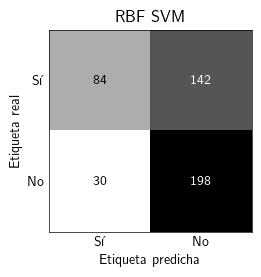

In [37]:
cu.train_and_evaluate_model(rsvm, X_train_scaled, y_train, X_test_scaled, y_test, 'RBF SVM', pos_class, neg_class)

# Regresión Logística

In [38]:
lr = LogisticRegression(max_iter=1000)
C_range = np.logspace(-3, 3, 7)
params = {'C': C_range}
best_lr = GridSearchCV(lr,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit =score_validation, verbose=3)
start = time.time()
best_lr.fit(X_train_scaled, y_train)
end = time.time()
best_score = best_lr.best_score_
best_C = best_lr.best_params_['C']
fu.write_cross_val_times_to_file(
        {"Classifier":'Logistic Regression', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best {score_validation}: {best_score}, best C: {best_C}')

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 1/10] END C=0.001; accuracy: (test=0.604) matthews_corrcoef: (test=0.227) total time=   0.0s
[CV 4/10] END C=0.001; accuracy: (test=0.599) matthews_corrcoef: (test=0.203) total time=   0.0s
[CV 2/10] END C=0.001; accuracy: (test=0.604) matthews_corrcoef: (test=0.215) total time=   0.0s
[CV 3/10] END C=0.001; accuracy: (test=0.621) matthews_corrcoef: (test=0.259) total time=   0.0s
[CV 5/10] END C=0.001; accuracy: (test=0.657) matthews_corrcoef: (test=0.345) total time=   0.0s
[CV 9/10] END C=0.001; accuracy: (test=0.641) matthews_corrcoef: (test=0.299) total time=   0.0s
[CV 7/10] END C=0.001; accuracy: (test=0.597) matthews_corrcoef: (test=0.203) total time=   0.0s
[CV 6/10] END C=0.001; accuracy: (test=0.492) matthews_corrcoef: (test=-0.019) total time=   0.0s
[CV 10/10] END C=0.001; accuracy: (test=0.608) matthews_corrcoef: (test=0.237) total time=   0.0s
[CV 8/10] END C=0.001; accuracy: (test=0.558) matthews_corrcoef:

Curvas de aprendizaje del clasificador Logistic Regression almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador Logistic Regression almacenado en curvas_de_aprendizaje/learning_curves_times.csv


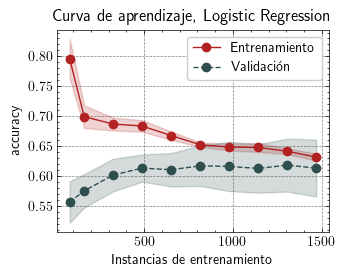

In [39]:
lr = LogisticRegression(C=best_C, max_iter=1000)
lcu.plot_and_save_learning_curve(lr, 'Logistic Regression', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10, y_label=score_validation)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
Predicciones del clasificador Logistic Regression almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador Logistic Regression almacenado en resultados/execution_times.csv
Accuracy: 0.6101
Balanced accuracy: 0.6093
Recall: 0.4204
Specificity: 0.7982
AUC: 0.4204
MCC: 0.2362
Precision: 0.6738
F1-score: 0.5177


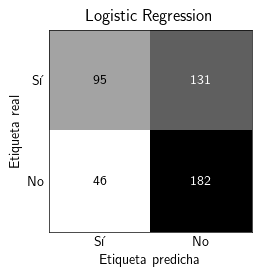

In [40]:
cu.train_and_evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression', pos_class, neg_class)

# Resultados

In [41]:
#predicciones = pd.read_csv(os.path.join(fu.results_path,'predicciones.csv'))
#cmu.plot_save_all_conf_matrices(predicciones,[pos_class[0],neg_class[0]] ,[pos_class[1],neg_class[1]])

In [42]:
resultados = pd.DataFrame(pd.read_csv(os.path.join(fu.results_path,'resultados.csv')))
resultados.sort_values(by='Accuracy', ascending=False, inplace=True)
markdown_table = resultados.to_markdown(index=False, floatfmt=".4f")
# Imprimir la tabla Markdown
print(markdown_table)

| Classifier          |   Accuracy |   Balanced_accuracy |   Recall |   Specificity |    AUC |    MCC |   Precision |   F1-score |
|:--------------------|-----------:|--------------------:|---------:|--------------:|-------:|-------:|------------:|-----------:|
| GBM                 |     0.6718 |              0.6717 |   0.6372 |        0.7061 | 0.6717 | 0.3442 |      0.6825 |     0.6590 |
| Decision Tree       |     0.6586 |              0.6581 |   0.5575 |        0.7588 | 0.6581 | 0.3230 |      0.6961 |     0.6192 |
| Random Forest       |     0.6542 |              0.6534 |   0.4823 |        0.8246 | 0.6534 | 0.3268 |      0.7315 |     0.5813 |
| RBF SVM             |     0.6211 |              0.6201 |   0.3717 |        0.8684 | 0.6201 | 0.2768 |      0.7368 |     0.4941 |
| MLP                 |     0.6123 |              0.6117 |   0.4646 |        0.7588 | 0.6117 | 0.2338 |      0.6562 |     0.5440 |
| Logistic Regression |     0.6101 |              0.6093 |   0.4204 |        0.7982

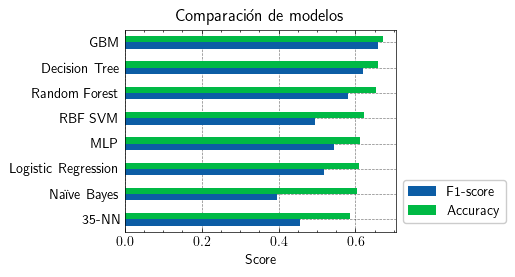

In [43]:
cu.plot_scores(resultados,['F1-score','Accuracy'], ['F1-score','Accuracy'], 'Accuracy', 'Comparación de modelos')

Learning curves de validación de todos los clasificadores

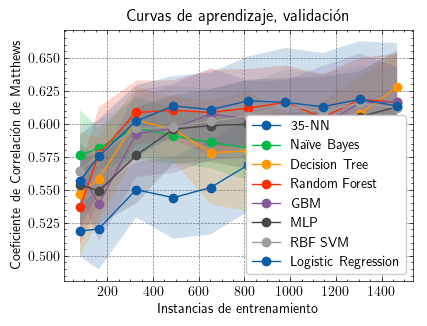

In [44]:
lcu.plot_and_save_all_learning_curves()

Tiempos de entrenamiento y prueba

In [50]:
tiempos_val = pd.read_csv(os.path.join(fu.results_path,'cross_val_times.csv'))
tiempos_e_p = pd.DataFrame(pd.read_csv(os.path.join(fu.results_path,'execution_times.csv')))
tiempos = pd.merge(tiempos_val, tiempos_e_p, on='Classifier')
tiempos.rename(columns={'time_s': 'val_s' }, inplace=True)
tiempos.sort_values(by='val_s', ascending=False, inplace=True)
markdown_table = tiempos.to_markdown(index=False, floatfmt=".4f")
# Imprimir la tabla Markdown
print(markdown_table)


| Classifier          |     val_s |   training_s |   testing_s |
|:--------------------|----------:|-------------:|------------:|
| MLP                 | 1413.1417 |       0.4146 |      0.0007 |
| GBM                 |   10.3965 |       1.8672 |      0.0047 |
| Random Forest       |    5.3843 |       0.4005 |      0.0328 |
| RBF SVM             |    3.4609 |       0.0470 |      0.0159 |
| Decision Tree       |    3.0867 |       0.0029 |      0.0005 |
| 35-NN               |    1.5958 |       0.0010 |      0.0281 |
| Logistic Regression |    0.0596 |       0.0030 |      0.0004 |
| Naïve Bayes         |    0.0000 |       0.0014 |      0.0005 |


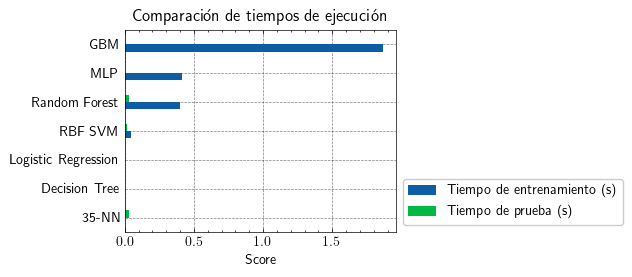

In [46]:
cu.plot_times(tiempos,['training_s','testing_s'], ['Tiempo de entrenamiento (s)','Tiempo de prueba (s)'], 'training_s', 'Comparación de tiempos de ejecución')

In [47]:
data = pd.read_csv(os.path.join(path_to_file))
for att in cat_atts:
    print(f'{att}: {len(data[att].unique())}')

sex: 2
usmarl: 3
usdocl: 8
reltrip: 3
paistrip: 3
sport: 3
social: 3
inus: 2
METROCAT: 4
pre_irca: 2
irca: 2
iirira: 2
pais_pre_irca: 2
pais_irca: 2
pais_iirira: 2


In [48]:
for att in [num_atts for num_atts in data.columns if num_atts not in cat_atts]:
    print(f'{att} -  min:{data[att].min()}, max:{data[att].max()}')

edyrs -  min:0.0, max:20.0
usdurl -  min:1, max:558
age -  min:5, max:72
minors -  min:0.0, max:11.0
land -  min:0, max:4
property -  min:0, max:6
business -  min:0, max:4
usunemp -  min:0.035, max:0.097
sons -  min:0, max:8
daus -  min:0, max:9
hrwage_adj_2019 -  min:0.0, max:61914.97046321526
target -  min:0, max:1
